[0.35 0.15]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
135.0


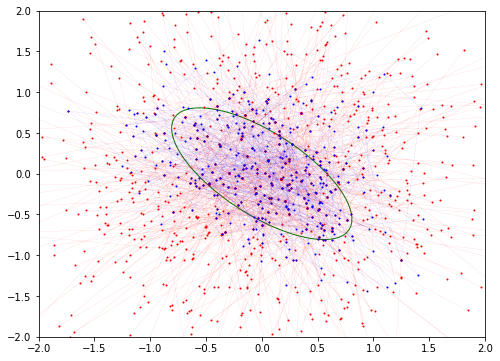

In [16]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import math
from scipy.stats import multivariate_normal

sampleNum = 1000
# Initial point 
previousSample = np.array([1.0, 1.0])

mu = np.array([0.0, 0.0])
# The widths of ellipse are 0.7 and 0.3.
# The covariance matrix has eigenvalue 0.35 for (1, -1) and 0.15 for (1, 1)
# Then, the covariance matrix is ((0.25, -0.1), (-0.1, 0.25))
covarianceMatrix = np.array([[0.25, -0.1], [-0.1, 0.25]])

def q(z, zGiven):
    # Now q(z | zGiven) = q(z) = N(z | 0, I)
    
    #mean = np.array([0.0, 0.0])
    #cov  = np.eye(2)
    
    #print(scipy.stats.multivariate_normal(mean, cov).pdf(z))
    #print(np.exp(-z.dot(z) / 2) / (2 * math.pi))    
    return np.exp(-z.dot(z) / 2) / (2 * math.pi)

def pTilde(z):
    #mean = np.array([0.0, 0.0])
    #cov  = covarianceMatrix
    
    #print(scipy.stats.multivariate_normal(mean, cov).pdf(z))
    #print(np.exp(-(z - mu).dot(np.linalg.inv(covarianceMatrix).dot(z - mu)) / 2) / (2 * math.pi) / (np.linalg.det(covarianceMatrix)**(1/2)))    
    
    return np.exp(-(z - mu).dot(np.linalg.inv(covarianceMatrix).dot(z - mu)) / 2)

class RejectedSample:
    def __init__(self, rejectedPoint, originalPoint):
        self.xs = [rejectedPoint[0], originalPoint[0]]
        self.ys = [rejectedPoint[1], originalPoint[1]]

#Draw a ellipse for p(z)
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

print(eigenValues)
print(eigenVectors)

angle = math.atan2(eigenVectors[0][0], eigenVectors[1][0]) / math.pi * 180
print(angle)

covarianceMatrixEllipse = patches.Ellipse(xy=mu, width=6*eigenValues[0], height=6*eigenValues[1], angle=angle, fill = False, color = "green")

sampledX = [previousSample[0]]
sampledY = [previousSample[1]]
rejectedSamples = []

for i in range(sampleNum):
    # Step 1 : Draw a sample from q(z | zGiven) = q(z)
    sample = multivariate_normal(np.array([0.0, 0.0]), np.eye(2)).rvs()

    # Step 2 : Calculate r
    r = (pTilde(sample) * q(previousSample, sample)) / (pTilde(previousSample) * q(sample, previousSample))
    
    # Step 3 : Update z (sample)
    threshold = np.random.rand()
    #print(threshold, " ", r, " ", min(1, r) > threshold)
    if min(1, r) > threshold:
        # Accepted
        sampledX.append(sample[0])
        sampledY.append(sample[1])
        previousSample = sample
    else:
        # Rejected
        rejectedSamples.append(RejectedSample(sample, previousSample))
    
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.add_patch(covarianceMatrixEllipse)
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

for r in rejectedSamples:
    plt.plot(r.xs, r.ys, color = "red", marker = "o", lw = 0.05, ms = 1)

plt.plot(sampledX, sampledY, color = "blue", marker = "o", lw = 0.05, ms = 1)

plt.show()


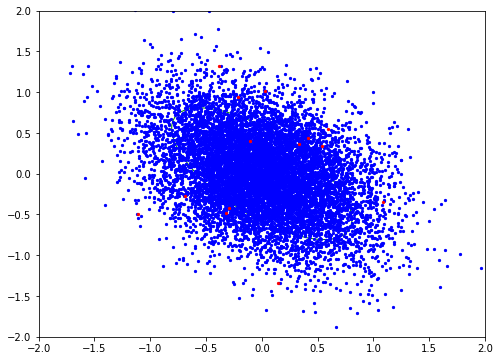

In [25]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import math
from scipy.stats import multivariate_normal

sampleNum = 10000
# Initial point 
previousSample = np.array([1.0, 1.0])
epsilon = 0.05
epsilonU = epsilon
epsilonP = epsilon
L = 30

mu = np.array([0.0, 0.0])
# The covariance matrix has eigenvalue 0.7 for (1, -1) and 0.3 for (1, 1)
# Then, the covariance matrix is ((0.5, -0.2), (-0.2, 0.5))
covarianceMatrix = np.array([[0.25, -0.1], [-0.1, 0.25]])

def U(z):
    # U = -ln p~(z)
    return (z - mu).dot(np.linalg.inv(covarianceMatrix).dot(z - mu)) / 2

def K(p):
    return p.dot(p) / 2

def H(z, p):
    return U(z) + K(p)

def dU(z):
    delta = 0.0001
    
    retValue = []
    
    for i in range(len(z)):
        zTmpPlus = np.array(z)
        zTmpMinus = np.array(z)
        
        zTmpPlus[i] = zTmpPlus[i] + delta / 2
        zTmpMinus[i] = zTmpMinus[i] - delta / 2
        retValue.append((U(zTmpPlus) - U(zTmpMinus)) / delta)
    
    return np.array(retValue)

class Path:
    xs = []
    ys = []
    def addPoint(self, point):
        self.xs.append(point[0])
        self.ys.append(point[1])

def calcP(z, p, zStar, pStar):
    return np.exp(-H(zStar, pStar) + H(z, p))

#Draw a ellipse for p(z)
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)
angle = math.atan2(eigenVectors[0][0], eigenVectors[1][0]) / math.pi * 180
covarianceMatrixEllipse = patches.Ellipse(xy=mu, width=6*eigenValues[0], height=6*eigenValues[1], angle=angle, fill = False, color = "green")

sampledX = [previousSample[0]]
sampledY = [previousSample[1]]
sampledPath = []
rejectedX = []
rejectedY = []
rejectedPath = []

for i in range(sampleNum):
    # Step 1 : Sample p.
    p = multivariate_normal(np.array([0.0, 0.0]), np.eye(2)).rvs()
    pInit = np.array(p)

    # Step 2 : calculate z* with leapfrog method
    z = np.array(previousSample)
    path = Path()
    path.addPoint(z)
    
    for j in range(L):
        p = p - epsilonU / 2 * dU(z)
        z = z + epsilonP * p
        p = p - epsilonU / 2 * dU(z)
        path.addPoint(z)
    
    # Step 3 : Calculate r
    r = calcP(previousSample, pInit, z, p)
    
    # Step 4 : Update z (sample)
    threshold = np.random.rand()
#    print(threshold, " ", r, " ", min(1, r) > threshold)
    if min(1, r) > threshold:
        # Accepted
        sampledX.append(z[0])
        sampledY.append(z[1])
        sampledPath.append(path)
        previousSample = z
    else:
        # Rejected
        rejectedX.append(z[0])
        rejectedY.append(z[1])
        rejectedPath.append(path)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.add_patch(covarianceMatrixEllipse)
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

#for p in sampledPath:
#    plt.plot(p.xs, p.ys, color = "blue", lw = 0.004)

#for p in rejectedPath:
#    plt.plot(p.xs, p.ys, color = "red", lw = 0.004)

plt.scatter(sampledX, sampledY, color = "blue", s = 5.0)
plt.scatter(rejectedX, rejectedY, color = "red", s = 5.0)

plt.show()

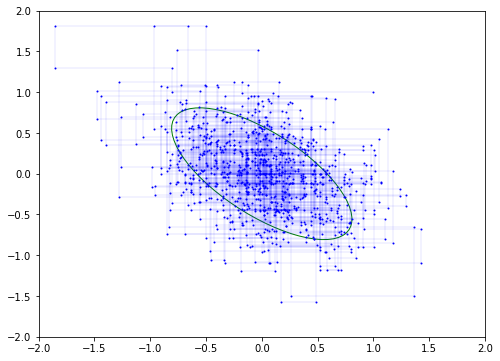

In [10]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.stats import norm

sampleNum = 1000
# Initial point 
previousSample = np.array([1.0, 1.0])

mu = np.array([0.0, 0.0])
covarianceMatrix = np.array([[0.25, -0.1], [-0.1, 0.25]])

def sampleFromPX1GivenX2(x2):
    # Refer to (A.7) - (A.9)
    sigmaInv = np.linalg.inv(covarianceMatrix)
    lambda1_2 = sigmaInv[0][0]
    mu1_2 = mu[0] - sigmaInv[0][1] / sigmaInv[0][0] * (x2 - mu[1])
    
    return norm.rvs(loc = mu1_2, scale = (1 / lambda1_2)**0.5)
    
def sampleFromPX2GivenX1(x1):
    # Refer to (A.7) - (A.9)
    # sigmaInv[0][1] = sigmaInv[1][0]
    sigmaInv = np.linalg.inv(covarianceMatrix)
    lambda2_1 = sigmaInv[1][1]
    mu2_1 = mu[1] - sigmaInv[0][1] / sigmaInv[1][1] * (x1 - mu[0])
    
    return norm.rvs(loc = mu2_1, scale = (1 / lambda2_1)**0.5)
    
#Draw a ellipse for p(z)
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)
angle = math.atan2(eigenVectors[0][0], eigenVectors[1][0]) / math.pi * 180
covarianceMatrixEllipse = patches.Ellipse(xy=mu, width=6*eigenValues[0], height=6*eigenValues[1], angle=angle, fill = False, color = "green")

sampledX = [previousSample[0]]
sampledY = [previousSample[1]]
selectX1 = True

for i in range(sampleNum):

    #print(sampledX[-1], " ", sampledY[-1])
    
    if selectX1:
        x = sampleFromPX1GivenX2(previousSample[1])
        sampledX.append(x)
        sampledY.append(previousSample[1])
        previousSample[0] = x
    else:
        y = sampleFromPX2GivenX1(previousSample[0])
        sampledX.append(previousSample[0])
        sampledY.append(y)
        previousSample[1] = y
        
    selectX1 = not selectX1

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.add_patch(covarianceMatrixEllipse)
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

plt.plot(sampledX, sampledY, color = "blue", marker = "o", lw = 0.1, ms = 1)

plt.show()


[0.35 0.15]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


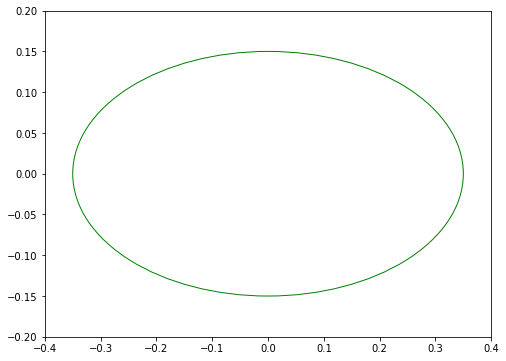

In [23]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches

mu = np.array([0.0, 0.0])
covarianceMatrix = np.array([[0.25, -0.1], [-0.1, 0.25]])

#Draw a ellipse for p(z)
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

print(eigenValues)
print(eigenVectors)

#angle = math.atan2(eigenVectors[0][0], eigenVectors[1][0]) / math.pi * 180
angle = 0

covarianceMatrixEllipse = patches.Ellipse(xy=mu, width=2*eigenValues[0], height=2*eigenValues[1], angle=angle, fill = False, color = "green")
    
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.add_patch(covarianceMatrixEllipse)
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.2, 0.2)

plt.show()
